# Compare Entities Across Documents

Input two or more documents scraped from the web to compare.

## Install & Import Key Modules

In [ ]:
!export API_KEY=api-key
!pip install news-please
!pip install nltk

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

## Entity Analysis

In [15]:
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

# Instantiates a client
client = language.LanguageServiceClient()

Get complete information about the entities mentioned in the text and their salience.

In [16]:
import six

def entities_text(text):
    """Returns complete information about the salience of entities in the text."""
    client = language.LanguageServiceClient()

    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    # Instantiates a plain text document.
    document = types.Document(
        content=text,
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects entities in the document
    entities = client.analyze_entities(document).entities

    # entity types from enums.Entity.Type
    entity_type = ('UNKNOWN', 'PERSON', 'LOCATION', 'ORGANIZATION',
                   'EVENT', 'WORK_OF_ART', 'CONSUMER_GOOD', 'OTHER')

    entity_info = {'UNKNOWN':{}, 'PERSON':{}, 'LOCATION':{}, 'ORGANIZATION':{},
                   'EVENT':{}, 'WORK_OF_ART':{}, 'CONSUMER_GOOD':{}, 'OTHER':{}}
    for entity in entities:
      name = entity.name
      ent_type = entity_type[entity.type]
      salience = entity.salience
      #url = entity.metadata.get('wikipedia_url', '-')
      entity_info[ent_type][name] = [salience]
        
    return entity_info

Get information about the top *n* most important entities in the text.

In [ ]:
# preprocessing tools
stop_list = stopwords.words('english')

wnl = WordNetLemmatizer()
' '.join([wnl.lemmatize(w) for w in user_input.split()])

In [45]:
import operator

def key_entities(text):
    """Returns information about the most important entities in the text."""
    client = language.LanguageServiceClient()

    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    # Instantiates a plain text document.
    document = types.Document(
        content=text,
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects entities in the document
    entities = client.analyze_entities(document).entities

    # entity types from enums.Entity.Type
    top_ten = {}
    
    for entity in entities:
      name = entity.name
      if name not in stop_list:
        if len(name) < 20:
          salience = entity.salience
          top_ten[name] = salience
      
    top_ten = sorted(top_ten.items(), key=lambda kv: kv[1])[-25:][::-1]
        
    return top_ten

## Test with Live URL

In [ ]:
# imports url transformer to analyze input url and get a recommended article
from sandbox import InputModel, OutputModel, News

In [ ]:
# load text of user input
user_input = OutputModel('http://www.foxnews.com/politics/2018/07/03/trump-administration-is-breaking-from-obama-era-affirmative-action-policies.html').process()
top_user = key_entities(user_input)

In [48]:
top_user

[('Barack Obama', 0.07166481763124466),
 ('Justice Department', 0.02999379113316536),
 ('recommendations', 0.027219101786613464),
 ('series', 0.023527802899479866),
 ('law', 0.021038632839918137),
 ('campus diversity', 0.013398558832705021),
 ('Harvard', 0.012755855917930603),
 ('conservatives', 0.011814221739768982),
 ('Edward Blum', 0.011214003898203373),
 ('place', 0.010747103951871395),
 ('forms', 0.010487095452845097),
 ('Jeff Sessions', 0.009140655398368835),
 ('American', 0.00868489034473896),
 ('Fox News', 0.007502513937652111),
 ('action', 0.006815220694988966),
 ('Trump White House', 0.006363943684846163),
 ('Trump', 0.0060112434439361095),
 ('Supreme Court', 0.00559181859716773),
 ('admissions', 0.005547790322452784),
 ('rulemaking', 0.005086863413453102),
 ('Fair Admissions', 0.005065307021141052),
 ('administrations', 0.004876621533185244),
 ('minority groups', 0.004659641999751329),
 ('programs', 0.004640277940779924),
 ('administration', 0.004366117995232344)]

In [ ]:
# load text of top recommended article
rec_article = News('http://www.foxnews.com/politics/2018/07/03/trump-administration-is-breaking-from-obama-era-affirmative-action-policies.html')
rec_article = rec_article.choose_news()
rec_url = rec_article['url'][0]
rec_text = OutputModel(rec_url).process()
top_rec = key_entities(rec_text)

## Streamlined Process for Comparing Entities

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def get_texts(url):
  
  # load text of user input
  user_input = OutputModel(url).process()
  top_user = key_entities(user_input)
  
  # load text of top recommended article
  rec_article = News(url)
  rec_article = rec_article.choose_news()
  rec_url = rec_article['url'][0]
  rec_text = OutputModel(rec_url).process()
  top_rec = key_entities(rec_text)
  
  return top_user, top_rec
  
def graph_info(top_list):
  '''get entities, values, and y-axis position'''
  
  crit_ent = [top_list[i][0] for i in range(0, len(top_list))]
  crit_val = np.asarray([top_list[i][1] for i in range(0, len(top_list))])
  y_pos = np.arange(len(crit_ent))
  
  return crit_ent, crit_val, y_pos

def preload(url):
  # get texts
  top_user, top_rec = get_texts(url)
  
  # load graph info
  crit_ent1, crit_val1, y_pos1 = graph_info(top_user)
  crit_ent2, crit_val2, y_pos2 = graph_info(top_rec)
  
  return crit_ent1, crit_val1, y_pos1, crit_ent2, crit_val2, y_pos2

In [ ]:
crit_ent1, crit_val1, y_pos1, crit_ent2, crit_val2, y_pos2 = preload('http://www.foxnews.com/politics/2018/07/03/trump-administration-is-breaking-from-obama-era-affirmative-action-policies.html')

### Plot Differences

In [111]:
def ent_plot(crit_ent1, crit_val1, y_pos1, seed):

  plt.rcdefaults()
  fig, ax = plt.subplots()
  
  if seed==1:
  
    ax.barh(y_pos, crit_val1, align='center', color='red', ecolor='black')
    ax.set_yticks(y_pos1)
    ax.set_yticklabels(crit_ent1)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Relevance')
    ax.set_title('Conservative Topics')
  
  else:
  
    ax.barh(y_pos, crit_val2, align='center', color='blue', ecolor='black')
    ax.set_yticks(y_pos2)
    ax.set_yticklabels(crit_ent2)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Relevance')
    ax.set_title('Liberal Topics')
  
  return ax

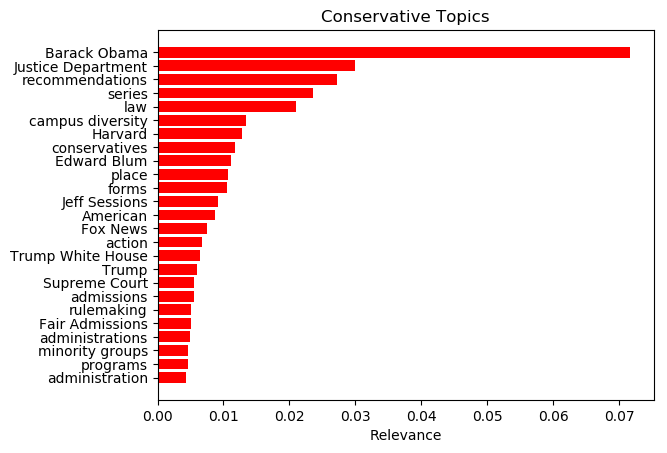

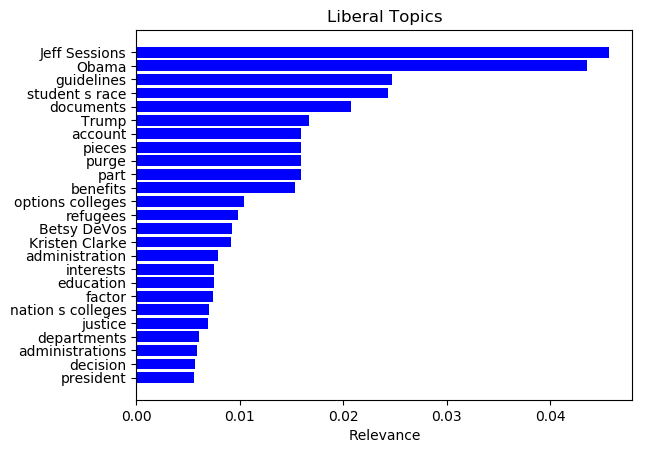

In [113]:
plt.show(ent_plot(crit_ent1, crit_val1, y_pos1, 1))
plt.show(ent_plot(crit_ent2, crit_val2, y_pos2, 2))

## Assess Sentiment for Document Entities

**Note**: Google's API returns relatively sparse data on sentiment. Working with Entity Salience seems more tractable.

In [103]:
import sys

def entity_sentiment_text(text):
    """Detects entity sentiment in the provided text."""
    client = language.LanguageServiceClient()

    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    document = types.Document(
        content=text.encode('utf-8'),
        type=enums.Document.Type.PLAIN_TEXT)

    # Detect and send native Python encoding to receive correct word offsets.
    encoding = enums.EncodingType.UTF32
    if sys.maxunicode == 65535:
        encoding = enums.EncodingType.UTF16

    result = client.analyze_entity_sentiment(document, encoding)

    # entity types from enums.Entity.Type
    entity_type = {0:'UNKNOWN', 1:'PERSON', 2:'LOCATION', 3:'ORGANIZATION',
                   4:'EVENT', 5:'WORK_OF_ART', 6:'CONSUMER_GOOD', 7:'OTHER'}

    entity_info = {'UNKNOWN':{}, 'PERSON':{}, 'LOCATION':{}, 'ORGANIZATION':{},
                   'EVENT':{}, 'WORK_OF_ART':{}, 'CONSUMER_GOOD':{}, 'OTHER':{}}

    for entity in result.entities:
      name = entity.name
      ent_type = entity_type[entity.type]
      salience = entity.salience
      sentiment = str(entity.sentiment).split()
      if len(sentiment) > 0:
        sentiment_mag = sentiment[1]
        entity_info[ent_type][name] = {'salience':salience, 'magnitude':sentiment[1]}
        if len(sentiment) > 2:
          sentiment = sentiment[3]
          entity_info[ent_type][name] = {'salience':salience, 'magnitude':sentiment[1], 'sentiment':sentiment[3]}
        
    return entity_info